In [ ]:
import pandas as pd 
import numpy as np
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from statsmodels.tsa.arima.model import ARIMA
register_matplotlib_converters()
from time import time

# Ice Cream Producation Data

In [44]:
def parser(s):
    return datetime.strptime(s, '%Y-%m-%d')

In [45]:
#read data
df_ice_cream = pd.read_csv('ice_cream.csv', 
                            parse_dates=[0], 
                            index_col=0, 
                            # squeeze=True, 
                            date_parser=parser)

#rename columns to something more understandable
df_ice_cream.rename(columns={'DATE':'date', 'IPN31152N':'production'}, inplace=True)

if df_ice_cream.shape[1] == 1:
    df_ice_cream = df_ice_cream.iloc[:, 0].squeeze()
else:
    df_ice_cream = df_ice_cream.squeeze()
    
df_ice_cream

/var/folders/lb/ycbntly138n0xkt0fdrnnk_w0000gn/T/ipykernel_6133/1156884190.py:2: FutureWarning:

The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.



DATE
1972-01-01     59.9622
1972-02-01     67.0605
1972-03-01     74.2350
1972-04-01     78.1120
1972-05-01     84.7636
                ...   
2019-09-01    100.1741
2019-10-01     90.1684
2019-11-01     79.7223
2019-12-01     75.7094
2020-01-01     83.6290
Name: production, Length: 577, dtype: float64

In [46]:
#infer the frequency of the data
df_ice_cream = df_ice_cream.asfreq(pd.infer_freq(df_ice_cream.index))
df_ice_cream

DATE
1972-01-01     59.9622
1972-02-01     67.0605
1972-03-01     74.2350
1972-04-01     78.1120
1972-05-01     84.7636
                ...   
2019-09-01    100.1741
2019-10-01     90.1684
2019-11-01     79.7223
2019-12-01     75.7094
2020-01-01     83.6290
Freq: MS, Name: production, Length: 577, dtype: float64

In [47]:
import plotly.express as px

fig = px.line(df_ice_cream)
fig.show()

In [48]:
start_date = datetime(2010,1,1)
selected_df_ice_cream = df_ice_cream[start_date:]
print(selected_df_ice_cream.shape)
selected_df_ice_cream

(121,)


DATE
2010-01-01     91.2895
2010-02-01    110.4994
2010-03-01    127.0971
2010-04-01    132.6468
2010-05-01    134.5576
                ...   
2019-09-01    100.1741
2019-10-01     90.1684
2019-11-01     79.7223
2019-12-01     75.7094
2020-01-01     83.6290
Freq: MS, Name: production, Length: 121, dtype: float64

In [49]:
import plotly.express as px

fig = px.line(selected_df_ice_cream)
fig.show()

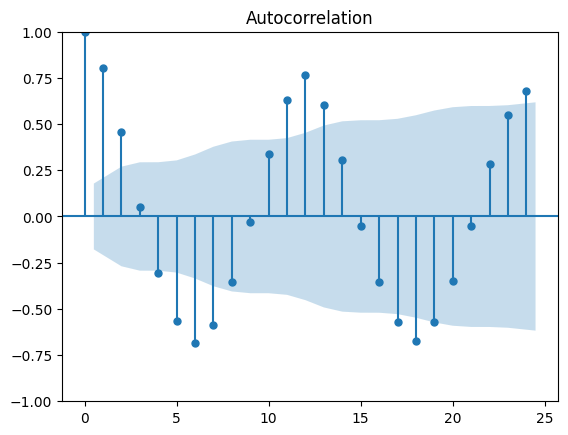

In [50]:
acf_plot = plot_acf(selected_df_ice_cream, lags=24)

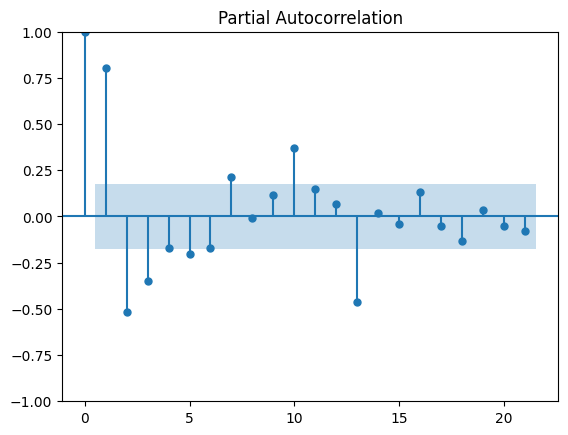

In [51]:
pacf_plot = plot_pacf(selected_df_ice_cream)

# Get training and testing data

In [52]:
train_end = datetime(2018, 12,1)
test_end = datetime(2019,12,1)

train_data = selected_df_ice_cream[:train_end]
test_data = selected_df_ice_cream[train_end + timedelta(days=1):test_end]

# Fit the AR Model

In [53]:
model = ARIMA(train_data, order=(3,0,0))

start = time()
model_fit = model.fit()
end = time()
print('Model Fitting Time:', end - start)

Model Fitting Time: 0.03251194953918457


In [54]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:             production   No. Observations:                  108
Model:                 ARIMA(3, 0, 0)   Log Likelihood                -374.085
Date:                Thu, 11 Sep 2025   AIC                            758.170
Time:                        09:20:41   BIC                            771.580
Sample:                    01-01-2010   HQIC                           763.607
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        103.5743      2.169     47.761      0.000      99.324     107.825
ar.L1          1.0469      0.102     10.256      0.000       0.847       1.247
ar.L2         -0.0523      0.175     -0.298      0.7

In [55]:
#get prediction start and end dates
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]

In [56]:
#get the predictions and residuals
predictions = model_fit.predict(start=pred_start_date, end=pred_end_date)
residuals = test_data - predictions

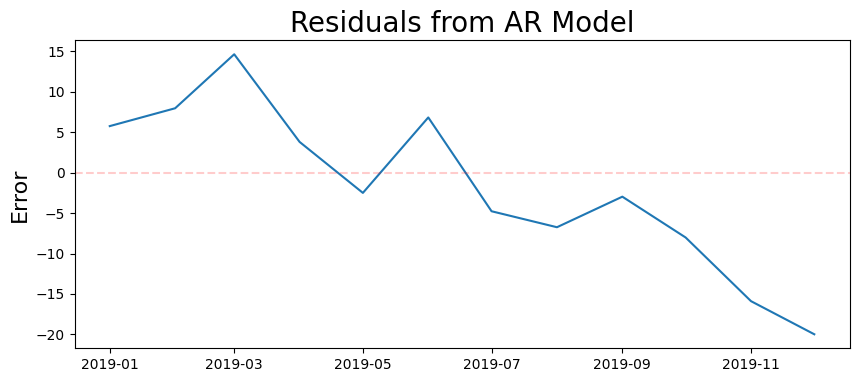

In [57]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.title('Residuals from AR Model', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.axhline(0, color='r', linestyle='--', alpha=0.2)

Text(0, 0.5, 'Sales')

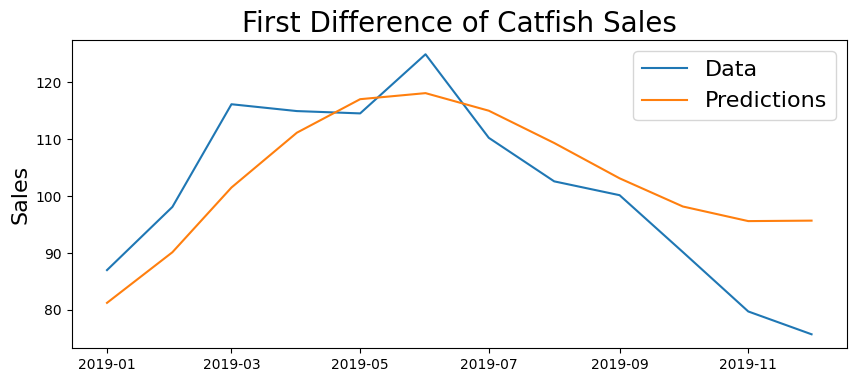

In [58]:
plt.figure(figsize=(10,4))

plt.plot(test_data)
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('First Difference of Catfish Sales', fontsize=20)
plt.ylabel('Sales', fontsize=16)

In [59]:
print('Mean Absolute Precent Error:', round(np.mean(abs(residuals/test_data)),4)*100, '%')

Mean Absolute Precent Error: 8.95 %


In [60]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: 9.884158745680441


# Stocks Example

In [61]:
import yfinance as yf
#define the ticker symbol
tickerSymbol = 'TSLA'

#get data on this ticker
tickerData = yf.Ticker(tickerSymbol)

#get the historical prices for this ticker
tickerDf = tickerData.history(period='1d', start='2020-1-1', end='2025-9-1')


tickerDf

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2020-01-02 00:00:00-05:00,28.299999,28.713333,28.114000,28.684000,142981500,0.0,0.0
2020-01-03 00:00:00-05:00,29.366667,30.266666,29.128000,29.534000,266677500,0.0,0.0
2020-01-06 00:00:00-05:00,29.364668,30.104000,29.333332,30.102667,151995000,0.0,0.0
2020-01-07 00:00:00-05:00,30.760000,31.441999,30.224001,31.270666,268231500,0.0,0.0
2020-01-08 00:00:00-05:00,31.580000,33.232666,31.215334,32.809334,467164500,0.0,0.0
...,...,...,...,...,...,...,...
2025-08-25 00:00:00-04:00,338.899994,349.529999,335.029999,346.600006,86670000,0.0,0.0
2025-08-26 00:00:00-04:00,344.929993,351.899994,343.720001,351.670013,76651600,0.0,0.0
2025-08-27 00:00:00-04:00,351.940002,355.390015,349.160004,349.600006,65519000,0.0,0.0


In [62]:
import plotly.express as px

fig = px.line(tickerDf['Close'])
fig.show()

In [63]:
tickerDf['FirstDifference'] = tickerDf['Close'].diff().dropna()
selected_df_tesla = tickerDf['FirstDifference'].dropna()
selected_df_tesla

Date
2020-01-03 00:00:00-05:00     0.850000
2020-01-06 00:00:00-05:00     0.568666
2020-01-07 00:00:00-05:00     1.167999
2020-01-08 00:00:00-05:00     1.538668
2020-01-09 00:00:00-05:00    -0.720001
                               ...    
2025-08-25 00:00:00-04:00     6.589996
2025-08-26 00:00:00-04:00     5.070007
2025-08-27 00:00:00-04:00    -2.070007
2025-08-28 00:00:00-04:00    -3.619995
2025-08-29 00:00:00-04:00   -12.110016
Name: FirstDifference, Length: 1422, dtype: float64

In [64]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd

# Assuming tickerDf is your DataFrame with the provided data
# Create a subplot figure with 2 rows and 1 column, sharing the x-axis
fig = make_subplots(rows=2, cols=1, 
                    shared_xaxes=True, 
                    vertical_spacing=0.1,
                    subplot_titles=("Close Price", "First Difference"))

# Add trace for Close price (first subplot)
fig.add_trace(
    go.Scatter(x=tickerDf.index, y=tickerDf['Close'], mode='lines', name='Close'),
    row=1, col=1
)

# Add trace for FirstDifference (second subplot)
fig.add_trace(
    go.Scatter(x=tickerDf.index, y=tickerDf['FirstDifference'], mode='lines', name='First Difference'),
    row=2, col=1
)

# Update layout for better appearance
fig.update_layout(
    height=600,
    width=1000,
    title_text="Close Price and First Difference Over Time",
    showlegend=True
)

# Update x-axis and y-axis titles
fig.update_xaxes(title_text="Date", row=2, col=1)  # Only set x-axis title for the bottom subplot
fig.update_yaxes(title_text="Close Price", row=1, col=1)
fig.update_yaxes(title_text="First Difference", row=2, col=1)

# Show the figure
fig.show()

# Check Missing Data

In [65]:
from statsmodels.tsa.stattools import adfuller
def perform_adf_test(series):
    result = adfuller(series)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    if result[1] <= 0.05:
        print("✅ The series is likely stationary.")
    else:
        print("❌ The series is likely non-stationary.")

In [66]:
perform_adf_test(tickerDf['Close'])

ADF Statistic: -2.775388
p-value: 0.061876
❌ The series is likely non-stationary.


# First Difference

In [67]:
import plotly.express as px

fig = px.line(selected_df_tesla)
fig.show()

In [68]:
perform_adf_test(selected_df_tesla)

ADF Statistic: -6.721166
p-value: 0.000000
✅ The series is likely stationary.


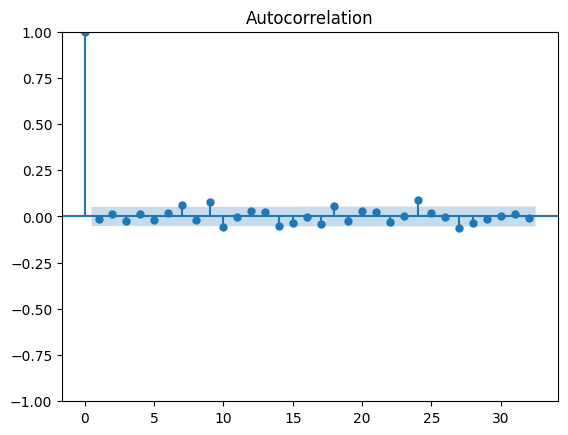

In [69]:
acf_plot = plot_acf(selected_df_tesla)

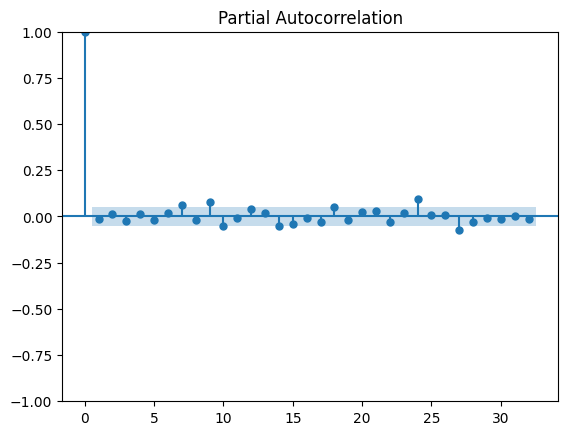

In [70]:
pacf_plot = plot_pacf(selected_df_tesla)

In [71]:
print(selected_df_tesla.shape)
selected_df_tesla


(1422,)


Date
2020-01-03 00:00:00-05:00     0.850000
2020-01-06 00:00:00-05:00     0.568666
2020-01-07 00:00:00-05:00     1.167999
2020-01-08 00:00:00-05:00     1.538668
2020-01-09 00:00:00-05:00    -0.720001
                               ...    
2025-08-25 00:00:00-04:00     6.589996
2025-08-26 00:00:00-04:00     5.070007
2025-08-27 00:00:00-04:00    -2.070007
2025-08-28 00:00:00-04:00    -3.619995
2025-08-29 00:00:00-04:00   -12.110016
Name: FirstDifference, Length: 1422, dtype: float64

In [72]:
selected_df_tesla = selected_df_tesla.tz_localize(None)

train_end = datetime(2025, 8,15)
test_end = datetime(2025,9,1)

train_data = selected_df_tesla[:train_end]
test_data = selected_df_tesla[train_end + timedelta(days=1):test_end]

- `train_data.asfreq('B')` sets the frequency of the Series’ index to business days (`'B'`) and returns a new Series with the updated index and data aligned to the specified frequency.

In [73]:
# Ensure the index has a frequency
train_data = train_data.asfreq('B')  # 'B' for business days

# Now fit the ARIMA model
model = ARIMA(train_data, order=(30, 0, 0))
start = time()
model_fit = model.fit()
end = time()
print('Model Fitting Time:', end - start)

Model Fitting Time: 4.735826015472412


In [74]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:        FirstDifference   No. Observations:                 1466
Model:                ARIMA(30, 0, 0)   Log Likelihood               -5146.389
Date:                Thu, 11 Sep 2025   AIC                          10356.778
Time:                        09:20:47   BIC                          10526.067
Sample:                    01-03-2020   HQIC                         10419.917
                         - 08-15-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2144      0.279      0.768      0.443      -0.333       0.762
ar.L1         -0.0111      0.025     -0.446      0.656      -0.060       0.038
ar.L2          0.0075      0.024      0.314      0.7

In [75]:
test_data = test_data.asfreq('B')  # 'B' for business days
#get prediction start and end dates
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]

In [76]:
#get the predictions and residuals
predictions = model_fit.predict(start=pred_start_date, end=pred_end_date)
residuals = test_data - predictions

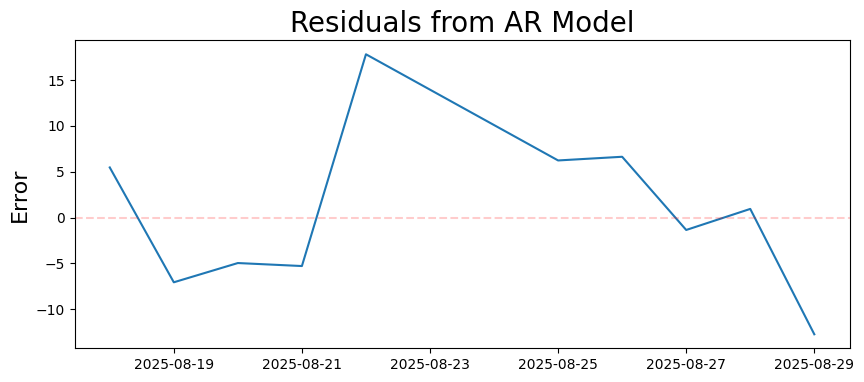

In [77]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.title('Residuals from AR Model', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.axhline(0, color='r', linestyle='--', alpha=0.2)

Text(0, 0.5, 'Sales')

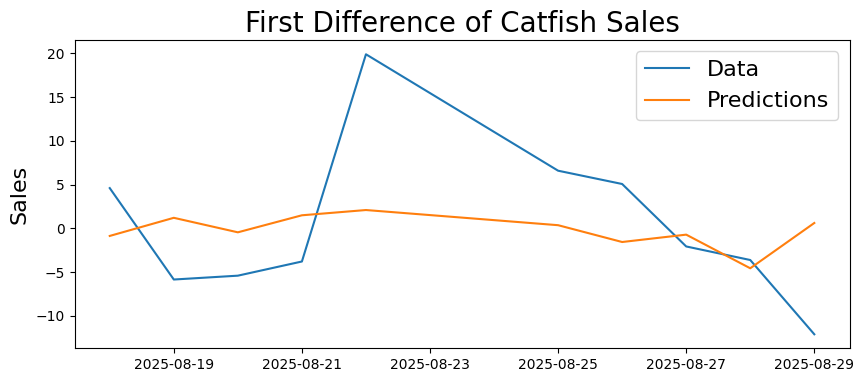

In [78]:
plt.figure(figsize=(10,4))

plt.plot(test_data)
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('First Difference of Catfish Sales', fontsize=20)
plt.ylabel('Sales', fontsize=16)

In [79]:
print('Mean Absolute Precent Error:', round(np.mean(abs(residuals/test_data)),4)*100, '%')

Mean Absolute Precent Error: 98.17 %


In [80]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: 8.346041711915737
